<IPython.core.display.Javascript object>


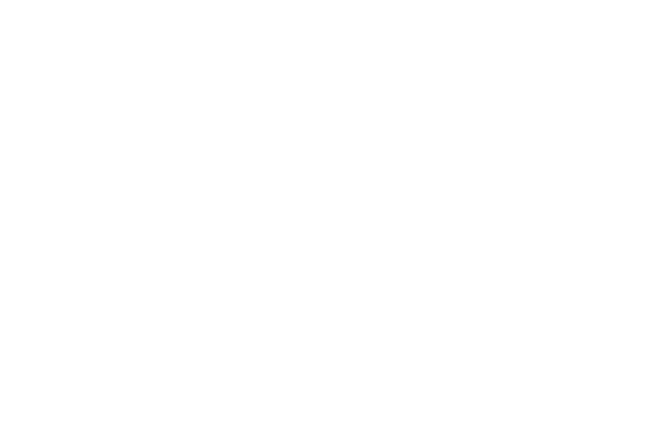

2021-10-29 Portfolio Value: 1000000.00
2019-11-29 Portfolio Value: 1000000.00
2019-12-31 Portfolio Value: 1005231.98
2020-01-31 Portfolio Value: 995953.88
2020-02-28 Portfolio Value: 908666.19
2020-03-31 Portfolio Value: 763563.44
2020-03-31 Portfolio Value: 763563.44
2020-04-30 Portfolio Value: 861778.27
2020-05-29 Portfolio Value: 905088.09
2020-06-30 Portfolio Value: 907411.35
2020-07-31 Portfolio Value: 952367.90
2020-08-31 Portfolio Value: 993557.56
2020-09-30 Portfolio Value: 972108.69
2020-10-30 Portfolio Value: 963884.11
2020-11-30 Portfolio Value: 1093855.01
2020-12-31 Portfolio Value: 1139392.13
2021-01-29 Portfolio Value: 1126312.07
2021-02-26 Portfolio Value: 1179190.43
2021-03-31 Portfolio Value: 1245735.04
2021-04-30 Portfolio Value: 1305209.18
2021-05-31 Portfolio Value: 1326603.54
2021-05-31 Portfolio Value: 1326603.54
2021-06-30 Portfolio Value: 1326424.49
2021-07-30 Portfolio Value: 1342685.61
2021-08-31 Portfolio Value: 1367274.40
2021-09-30 Portfolio Value: 1312449.

<IPython.core.display.Javascript object>


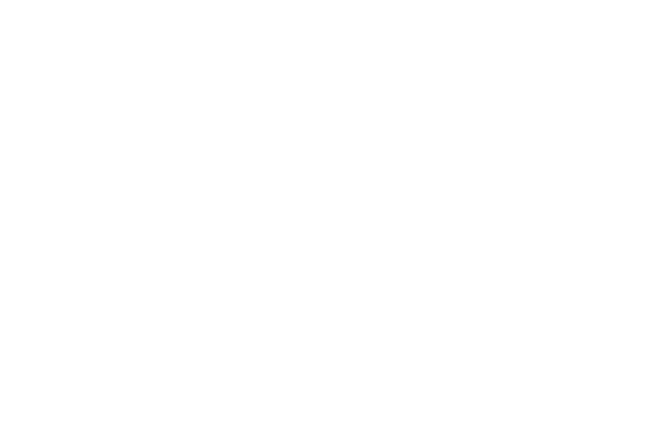

[[<Figure size 432x288 with 2 Axes>]]

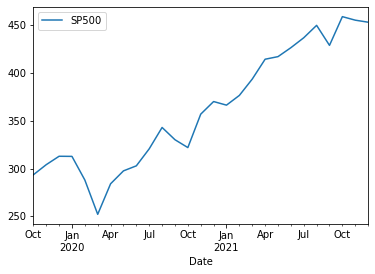

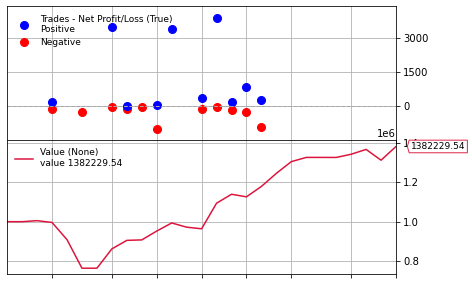

In [6]:
from __future__ import (absolute_import,division,print_function,
                        unicode_literals)
import datetime
from dateutil.relativedelta import relativedelta
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy.optimize import minimize
from pykalman import KalmanFilter
from arch.univariate import arch_model
import backtrader as bt

import DCC
import ARIMA
import stock_data_preprocessor as sdp
from covariance_matrix import covariance_matrix

end = datetime.date(2021, 10, 31)
start = end + relativedelta(months=-24)
class highest_sharpe_ratio(bt.Strategy):
    
    def __init__(self):
        today = self.data.datetime.date()
        self.weights = pd.read_csv('final_weights.csv',index_col='Date',parse_dates=True)
        self.i = 0
        for column_name in self.weights.columns:
            ratio = self.weights[column_name].iloc[self.i]
            self.order_target_percent(target=ratio,data=column_name)
        print(today,'Portfolio Value: %.2f' % cerebro.broker.getvalue())
        
        self.portfolio_value = pd.DataFrame()

    def next(self):        
        today = self.data.datetime.date()    
        if self.i < 24:
            self.i=self.i+1
        #print(self.i)
        for column_name in self.weights.columns:
            ratio = self.weights[column_name].iloc[self.i]
            self.order_target_percent(target=ratio,data=column_name)

        print(today,'Portfolio Value: %.2f' % cerebro.broker.getvalue())

        #self.portfolio_value.append(cerebro.broker.getvalue())
        #self.portfolio_value.to_csv(f'stock_data1/portfolio_value.csv')
        
        self.portfolio_value[today]=cerebro.broker.getvalue()
        self.portfolio_value.to_csv(f'stock_data1/portfolio_value.csv')

dummy_df = pd.read_csv('stock_data1/MMM.csv',
                       index_col='Date',
                       parse_dates=True)[start:end]
dummy_df.loc[:,:] = 0

# 1.creating a cerebro
cerebro = bt.Cerebro(stdstats=False)
cerebro.addobserver(bt.observers.Trades)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)
cerebro.broker.set_cash(1000000.0)
    
path1 = 'stock_data1/'
symbols = pd.read_csv('S&P500_ticker1.csv', usecols=['Symbol'])
for symbol in symbols.values:
    file_path = path1 + symbol[0] + '.csv'
    price_matrix = pd.read_csv(file_path,
                                index_col='Date',
                                parse_dates=True)[start:end]
    matrix_start = price_matrix.index[0]
    price_matrix = pd.concat([dummy_df[:matrix_start][1:], price_matrix])
    datafeed = bt.feeds.PandasData(dataname=price_matrix,plot=False)
    cerebro.adddata(datafeed,name=symbol[0])

# 3.add strategies
cerebro.addstrategy(highest_sharpe_ratio)
cerebro.addanalyzer(bt.analyzers.SharpeRatio)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer)
  
SP500 = pd.read_csv('stock_data1/SP500.csv',index_col='Date', parse_dates=True)
SP500.plot()
    
# 4.run
res = cerebro.run()[0]
print('Final Portfolio Value:',cerebro.broker.get_value())   
    
sharpe_ratio = res.analyzers.sharperatio.get_analysis()
print('==========Sharpe Ratio==========')
print('SharpeRatio:',sharpe_ratio['sharperatio'])
    
drawdown_data = res.analyzers.drawdown.get_analysis()
print('==========Draw Down==========')
print('Max Drawdown:',drawdown_data['max']['drawdown'])
print('Max Moneydown:',drawdown_data['max']['moneydown'])
    
trading_analyzer = res.analyzers.tradeanalyzer.get_analysis()
print('==========Trade Analysis==========')
#print('Total pnl',trading_analyzer['pnl'])
print('Maximum Won:',trading_analyzer['won']['pnl']['max'])
print('Maximum Lost:',trading_analyzer['lost']['pnl']['max'])

print()

# 5.plot results
cerebro.plot(style='candle',volume=False)
